In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

In [2]:
# I could easily use the boxscores from in the db instead of pulling from ESPN

In [3]:
league_id = 84057
# I am team 10

In [4]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%(AUTH['db_user'],AUTH['db_pass'],dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [5]:
url = 'https://fantasy.espn.com/apis/v3/games/FBA/seasons/2020/segments/0/leagues/' + str(league_id)
params={"view": "kona_player_info"}
cookies = {"swid": AUTH['swid'],
           "espn_s2": AUTH['espn_s2']}
r = requests.get(url, params=params, cookies=cookies)
data = r.json()
data.keys()

dict_keys(['players'])

In [6]:
stat_list = []
team_id_list = []
injured_list = []
injuryStatus_list = []
for player in data['players']:
    #print(player['player']['fullName'])
    for stat_item in player['player']['stats']:
        #looks like season totals AND averages id = '002020'
        if stat_item['id'] == '002020':
            if '40' in stat_item['stats'].keys(): # '40' is minutes
                stat_item['stats']['playerName'] = player['player']['fullName']
                stat_list.append(stat_item['stats'])
                team_id_list.append(player['onTeamId'])
                injured_list.append(player['player']['injured'])
                injuryStatus_list.append(player['player']['injuryStatus'])

In [7]:
stats_df = pd.DataFrame(stat_list)
stats_df['onTeamId'] = team_id_list
stats_df['injured'] = injured_list
stats_df['injuryStatus'] = injuryStatus_list
stats_df.shape

(470, 48)

In [8]:
col_rename_dict = {'0':'pts', '1':'blocks', '2':'steals', '3':'ast', '6':'reb', '13':'fgm', '14': 'fga', 
                   '15': 'ftm', '16':'fta', '17':'threes', '40':'min', '42':'gp'}
stats_df.rename(columns=col_rename_dict, inplace=True)
stats_df['fg_pct'] = stats_df['fgm'] / stats_df['fga']
stats_df['ft_pct'] = stats_df['ftm'] / stats_df['fta']
stats_df = stats_df[['playerName','onTeamId','injuryStatus','pts','blocks','steals','ast','reb','fgm','fga','fg_pct','ftm','fta','ft_pct','threes','min','gp']]

In [9]:
stats_df.head()

,playerName,onTeamId,injuryStatus,pts,blocks,steals,ast,reb,fgm,fga,fg_pct,ftm,fta,ft_pct,threes,min,gp
0,Vince Carter,0,ACTIVE,217.0,19.0,17.0,40.0,88.0,77.0,223.0,0.345291,19.0,25.0,0.760000,44.0,639.0,42.0
1,Tyson Chandler,0,ACTIVE,34.0,8.0,6.0,6.0,66.0,14.0,18.0,0.777778,6.0,13.0,0.461538,0.0,221.0,25.0
2,LeBron James,6,ACTIVE,1134.0,22.0,59.0,482.0,345.0,434.0,882.0,0.492063,172.0,248.0,0.693548,94.0,1568.0,45.0
3,Carmelo Anthony,12,DAY_TO_DAY,522.0,18.0,31.0,52.0,220.0,200.0,466.0,0.429185,75.0,90.0,0.833333,47.0,1073.0,33.0
4,Kyle Korver,0,ACTIVE,269.0,9.0,19.0,51.0,84.0,87.0,204.0,0.426471,26.0,31.0,0.838710,69.0,702.0,42.0


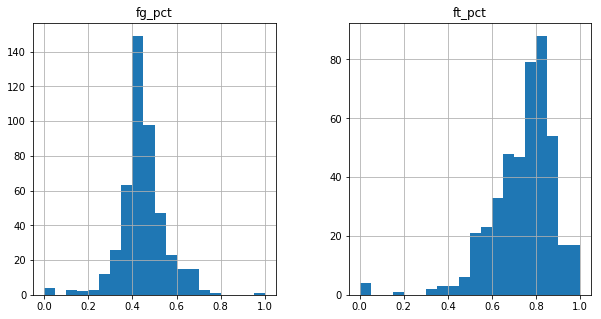

In [10]:
stats_df[['ft_pct', 'fg_pct']].hist(bins=20, figsize=(10,5));

In [11]:
stats_df.loc[:,'ast_rank'] = stats_df.apply(lambda x: ( (x['ast'] - stats_df['ast'].mean()) / stats_df['ast'].std()) , axis = 1)
stats_df.loc[:,'blocks_rank'] = stats_df.apply(lambda x: ( (x['blocks'] - stats_df['blocks'].mean()) / stats_df['blocks'].std()) , axis = 1)
stats_df.loc[:,'steals_rank'] = stats_df.apply(lambda x: ( (x['steals'] - stats_df['steals'].mean()) / stats_df['steals'].std()) , axis = 1)
stats_df.loc[:,'reb_rank'] = stats_df.apply(lambda x: ( (x['reb'] - stats_df['reb'].mean()) / stats_df['reb'].std()) , axis = 1)
stats_df.loc[:,'pts_rank'] = stats_df.apply(lambda x: ( (x['pts'] - stats_df['pts'].mean()) / stats_df['pts'].std()) , axis = 1)
stats_df.loc[:,'threes_rank'] = stats_df.apply(lambda x: ( (x['threes'] - stats_df['threes'].mean()) / stats_df['threes'].std()) , axis = 1)
stats_df.loc[:,'fta_rank'] = stats_df.apply(lambda x: ( (x['fta'] - stats_df['fta'].mean()) / stats_df['fta'].std()) , axis = 1)
stats_df.loc[:,'fga_rank'] = stats_df.apply(lambda x: ( (x['fga'] - stats_df['fga'].mean()) / stats_df['fga'].std()) , axis = 1)
stats_df.loc[:,'ft_pct_rank'] = stats_df.apply(lambda x: ( (x['ft_pct'] - stats_df['ft_pct'].mean()) / stats_df['ft_pct'].std()) , axis = 1)
stats_df.loc[:,'fg_pct_rank'] = stats_df.apply(lambda x: ( (x['fg_pct'] - stats_df['fg_pct'].mean()) / stats_df['fg_pct'].std()) , axis = 1)
stats_df['fg_rank_adj'] = stats_df['fg_pct_rank'] * stats_df['fga_rank']
stats_df['ft_rank_adj'] = stats_df['ft_pct_rank'] * stats_df['fta_rank']

cat_ranks = ['ast_rank','blocks_rank','steals_rank','reb_rank','pts_rank','threes_rank','fg_rank_adj','ft_rank_adj']
stats_df['total_rank'] = stats_df[cat_ranks].sum(axis=1)
stats_df.sort_values('total_rank', inplace=True, ascending= False)

final_stats_df = stats_df[['playerName','onTeamId','injuryStatus','total_rank'] + cat_ranks]

In [12]:
# how to properly account for fga and fta in their ranks? Did what I did make sense? doesn't appear to match up well with website
# do I need to remove anyone when I calculate the ranks?

In [13]:
my_team = final_stats_df.loc[final_stats_df.onTeamId==10]
my_team

,playerName,onTeamId,injuryStatus,total_rank,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj
266,Nikola Jokic,10,ACTIVE,12.895566,3.131471,0.631116,1.531371,2.994506,2.107668,0.650291,1.165772,0.683370
223,Giannis Antetokounmpo,10,DAY_TO_DAY,11.374909,2.194677,1.723051,1.324116,3.683125,3.266414,0.857152,2.694644,-4.368270
195,Buddy Hield,10,ACTIVE,8.164315,0.945618,-0.024046,0.857793,0.886142,2.114347,3.649773,-0.527907,0.262596
119,Tomas Satoransky,10,ACTIVE,6.155239,2.469470,-0.460820,2.360391,0.410060,0.591615,0.417573,0.011547,0.355404
254,Julius Randle,10,ACTIVE,5.786692,0.983089,-0.133239,0.650538,2.552430,1.837183,0.417573,0.028203,-0.549084
46,Derrick Rose,10,ACTIVE,5.632701,2.244639,-0.133239,0.598724,-0.244553,1.573376,0.107282,0.850806,0.635666
203,Kris Dunn,10,DAY_TO_DAY,5.631117,1.232901,0.085148,4.018430,0.401559,0.104073,-0.203010,-0.007476,-0.000508
192,Taurean Prince,10,ACTIVE,5.111712,0.308597,0.139745,1.116862,1.396230,0.832046,2.046601,-0.670895,-0.057474
397,Miles Bridges,10,ACTIVE,4.137903,0.133729,1.067890,0.287842,1.005163,0.812010,0.857152,-0.084803,0.058920
438,PJ Washington,10,DAY_TO_DAY,3.962345,0.171201,1.122487,0.805979,0.775623,0.608311,0.572718,0.174627,-0.268602


In [14]:
my_team[cat_ranks].sum()

ast_rank       12.913890
blocks_rank    11.729248
steals_rank    16.361453
reb_rank       16.333668
pts_rank       13.054502
threes_rank     6.673461
fg_rank_adj     2.326517
ft_rank_adj    -2.586896
dtype: float64

In [15]:
team_stats_list = []
for team_id in range(1, 13):
    team_stats = final_stats_df.loc[(final_stats_df.onTeamId==team_id) & (final_stats_df.injuryStatus!= 'OUT')]
    print(team_stats.shape)
    team_stats_list.append(team_stats[cat_ranks].sum())

(13, 12)
(12, 12)
(12, 12)
(13, 12)
(13, 12)
(12, 12)
(13, 12)
(12, 12)
(12, 12)
(13, 12)
(13, 12)
(13, 12)


In [16]:
team_rater = pd.concat(team_stats_list, axis=1).transpose()
team_ranks = team_rater.rank(ascending=False)
team_rater['teamId'] = list(range(1,13))
team_ranks['teamId'] = list(range(1,13))

In [17]:
team_rater

,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj,teamId
0,9.707475,7.112567,8.560621,5.942887,10.419220,6.721325,5.143968,5.361910,1
1,3.428375,11.613550,6.148416,14.161815,11.918023,6.071034,1.023913,-1.563383,2
2,14.045378,5.225726,8.739102,8.941915,11.928041,7.208768,1.999998,4.248419,3
3,10.706723,11.043536,7.006209,16.425195,17.615466,12.513427,1.502750,7.028000,4
4,15.328242,7.494745,11.514003,9.522004,13.307736,10.755111,2.222517,4.820391,5
5,13.683151,5.116532,12.106995,9.477507,10.826064,11.966567,1.525383,1.070101,6
6,9.445173,7.767729,10.684983,10.678204,14.089138,11.737699,1.116639,9.316816,7
7,5.988946,19.093309,12.469691,11.237311,9.416868,4.390290,0.088885,-0.059220,8
8,8.312196,3.751612,8.687289,9.494510,11.861254,7.881066,2.717219,6.869441,9
9,13.367219,10.825149,16.747190,15.013951,13.053948,7.600484,2.506009,-2.609911,10


In [26]:
next_macthup_ranks = team_ranks.loc[team_ranks.teamId.isin([10])]
next_macthup_ranks

,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj,teamId
9,4.0,4.0,1.0,2.0,6.0,8.0,3.0,12.0,10


In [27]:
#next_macthup_ranks.diff()

In [20]:
next_macthup_rater = team_rater.loc[team_rater.teamId.isin([10,5])]
next_macthup_rater

,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj,teamId
4,15.328242,7.494745,11.514003,9.522004,13.307736,10.755111,2.222517,4.820391,5
9,13.367219,10.825149,16.747190,15.013951,13.053948,7.600484,2.506009,-2.609911,10


In [22]:
final_stats_df.loc[final_stats_df.playerName=='Jrue Holiday']

,playerName,onTeamId,injuryStatus,total_rank,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj
58,Jrue Holiday,8,ACTIVE,8.752396,2.244639,1.013293,2.412205,0.444066,1.523286,1.219158,-0.030145,-0.074107


In [23]:
final_stats_df.loc[final_stats_df.playerName=='Buddy Hield']

,playerName,onTeamId,injuryStatus,total_rank,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj
195,Buddy Hield,10,ACTIVE,8.164315,0.945618,-0.024046,0.857793,0.886142,2.114347,3.649773,-0.527907,0.262596


In [24]:
final_stats_df.loc[final_stats_df.playerName=='Mitchell Robinson']

,playerName,onTeamId,injuryStatus,total_rank,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj
450,Mitchell Robinson,8,ACTIVE,4.006223,-0.628197,3.852326,0.805979,1.404732,0.264361,-0.95288,-0.29166,-0.448437


In [25]:
final_stats_df.loc[final_stats_df.playerName=='Julius Randle']

,playerName,onTeamId,injuryStatus,total_rank,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj
254,Julius Randle,10,ACTIVE,5.786692,0.983089,-0.133239,0.650538,2.55243,1.837183,0.417573,0.028203,-0.549084
